<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите файл с ответами в соответствующем Programming Assignment. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/12VB7kmzDoSVzSpQNaJp0tR-2t8K8PynQopP3dypf7i4).  

In [1]:
# pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.7.5
IPython 7.9.0

numpy 1.17.3
scipy 1.3.1
pandas 0.24.2
matplotlib 3.0.3
statsmodels 0.10.1
sklearn 0.0

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 26 Stepping 5, GenuineIntel
CPU cores  : 8
interpreter: 64bit
Git hash   : afc47c68782ce5002bde489eced84371841cc252


In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.6.1
IPython 5.3.0

numpy 1.13.3
scipy 0.19.0
pandas 0.20.1
matplotlib 2.1.0
statsmodels 0.8.0
sklearn 0.19.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)
system     : Darwin
release    : 16.7.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : ca8e6e4e47061a4c44a8506c9741b1c65fc9249a


In [3]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [4]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = os.path.join('.', '..', 'data', 'capstone_user_identification')

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [5]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [6]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [8]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [9]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [10]:
from sklearn.neighbors import KNeighborsClassifier

In [11]:
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)

In [12]:
%%time
accu_train = cross_val_score(knn, X_train, y_train, scoring='accuracy', cv=skf)

Wall time: 4.58 s


In [13]:
%%time
knn.fit(X_train, y_train)
y_predict = knn.predict(X_valid)
accu_valid = accuracy_score(y_valid, y_predict)

Wall time: 2.68 s


**<font color='red'>Вопрос 1. </font> Посчитайте доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [14]:
with open('./answers/week4_ans1.txt', 'w') as fo:
    accu1 = '{:.3f}'.format(accu_train.mean())
    accu2 = '{:.3f}'.format(accu_valid.mean())
    ans = accu1 + ' ' + accu2
    fo.write(ans)

**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
%%time
forest = RandomForestClassifier(n_estimators=100, random_state=17, oob_score=True, n_jobs=-1)
scores = cross_val_score(forest, X_train, y_train, cv=skf)

Wall time: 19.8 s


In [17]:
%%time
forest = RandomForestClassifier(n_estimators=100, random_state=17, oob_score=True, n_jobs=-1)
forest.fit(X_train, y_train)
y_predict = forest.predict(X_valid)
score2 = accuracy_score(y_valid, y_predict)

Wall time: 5.44 s


In [18]:
score1 = '{:.3f}'.format(scores.mean())
score2 = '{:.3f}'.format(score2)
# print('oob score fore train dataset: {:.3f}'.format(forest.oob_score_))
# print('oob score fore test dataset: {:.3f}'.format(forest.score(X_valid, y_valid)))

**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [72]:
with open('./answers/week4_ans2.txt', 'w') as fo:
    ans = score1 + ' ' + score2
    fo.write(ans)

**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [19]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [20]:
logit = LogisticRegression(random_state=17)

In [21]:
%%time
accu_train = cross_val_score(logit, X_train, y_train, scoring='accuracy', cv=skf, n_jobs=-1)
logit.fit(X_train, y_train)
y_predict = logit.predict(X_valid)
accu_valid = accuracy_score(y_valid, y_predict)

Wall time: 4.16 s


In [69]:
# with open('./answers/week4_ans2.txt', 'w') as fo:
#     accu1 = '{:.3f}'.format(accu_train.mean())
#     accu2 = '{:.3f}'.format(accu_valid.mean())
#     ans = accu1 + ' ' + accu2
#     fo.write(ans)

**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [22]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(logit_c_values1, multi_class='multinomial', random_state=17, cv=skf, n_jobs=-1)
logit_grid_searcher1.fit(X_train, y_train)

Wall time: 21.5 s


LogisticRegressionCV(Cs=array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02]),
                     class_weight=None,
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='multinomial',
                     n_jobs=-1, penalty='l2', random_state=17, refit=True,
                     scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [23]:
logit_mean_cv_scores1 = list(logit_grid_searcher1.scores_.values())[0].mean(axis=0)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [24]:
assert (logit_grid_searcher1.Cs_ == logit_c_values1).all()
i = np.argmax(logit_mean_cv_scores1)
print('best score is {:.3f} correspond to C={}'.format(logit_mean_cv_scores1[i], logit_c_values1[i]))

best score is 0.753 correspond to C=1.0


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

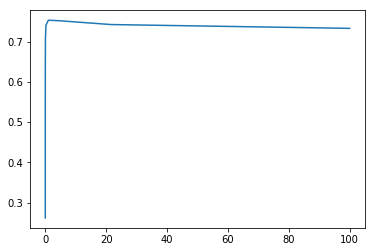

In [25]:
plt.plot(logit_c_values1, logit_mean_cv_scores1);

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

Здесь следует отметить, что **LogisticRegressionCV** действительно работает быстрее чем **GridSearchCV**, только вот ответы от него не прожёвываются грейдером. Убил я на выяснение этого ни 1 день, но теперь ответ вроде как принят и модно двигаться дальше.
Я дурной, просто ошибся в нумерации ответов

Ну пусть тут будет использование алгоритма гридсёрчера

In [97]:
%%time
logit_c_values2 = np.logspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(logit_c_values2, multi_class='multinomial', random_state=17, cv=skf, n_jobs=-1)
logit_grid_searcher2.fit(X_train, y_train)

Wall time: 48.9 s


LogisticRegressionCV(Cs=array([1.25892541e+00, 2.90507865e+00, 6.70371881e+00, 1.54694077e+01,
       3.56969885e+01, 8.23738707e+01, 1.90084790e+02, 4.38637001e+02,
       1.01219260e+03, 2.33572147e+03, 5.38987815e+03, 1.24376073e+04,
       2.87008485e+04, 6.62296762e+04, 1.52830673e+05, 3.52669921e+05,
       8.13816172e+05, 1.87795080e+06, 4.33353297e+06, 1.00000000e+07]),
                     class_weight=None,
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='multinomial',
                     n_jobs=-1, penalty='l2', random_state=17, refit=True,
                     scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [98]:
logit_mean_cv_scores2 = list(logit_grid_searcher2.scores_.values())[0].mean(axis=0)

In [100]:
assert (logit_grid_searcher2.Cs_ == logit_c_values2).all()
i = np.argmax(logit_mean_cv_scores2)
accu_train = logit_mean_cv_scores2[i]
print('best score is {:.3f} correspond to C={}'.format(logit_mean_cv_scores2[i], logit_c_values2[i]))

best score is 0.754 correspond to C=2.9050786505108603


In [125]:
logit_mean_cv_scores2_1 = list(logit_grid_searcher2.scores_.values())[0][:, 0]
i = np.argmax(logit_mean_cv_scores2_1)
accu_train = logit_mean_cv_scores2_1[i]
print('best score is {:.5f} correspond to C={}'.format(logit_mean_cv_scores2_1[i], logit_c_values2[i]))

best score is 0.75686 correspond to C=6.703718811765353


In [126]:
logit_mean_cv_scores2_2 = list(logit_grid_searcher2.scores_.values())[0][:, 1]
i = np.argmax(logit_mean_cv_scores2_2)
accu_train = logit_mean_cv_scores2_2[i]
print('best score is {:.5f} correspond to C={}'.format(logit_mean_cv_scores2_2[i], logit_c_values2[i]))

best score is 0.75616 correspond to C=1.2589254117941673


In [127]:
logit_mean_cv_scores2_3 = list(logit_grid_searcher2.scores_.values())[0][:, 0]
i = np.argmax(logit_mean_cv_scores2_3)
accu_train = logit_mean_cv_scores2_3[i]
print('best score is {:.5f} correspond to C={}'.format(logit_mean_cv_scores2_3[i], logit_c_values2[i]))

best score is 0.75686 correspond to C=6.703718811765353


In [101]:
logit = LogisticRegression(random_state=17, C=logit_c_values2[i])
logit.fit(X_train, y_train)
y_predict = logit.predict(X_valid)
accu_valid = accuracy_score(y_valid, y_predict)
print('{:.3f}'.format(accu_valid))

0.776


In [29]:
i = np.argmax(logit_grid_searcher.cv_results_['mean_test_score'])
accu_train = logit_grid_searcher.cv_results_['mean_test_score'][i]
print('best score is {:.3f} correspond to C={} with index {}'.format(accu_train, logit_grid_searcher.cv_results_['param_C'][i], i))

best score is 0.758 correspond to C=2.642105263157895 with index 7


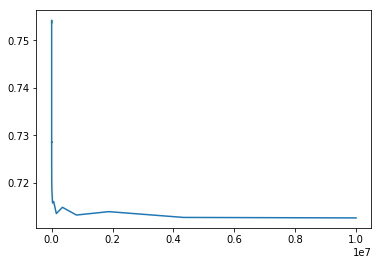

In [104]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [31]:
# y_predict = logit_grid_searcher2.predict(X_valid)
# logit_cv_acc = accuracy_score(y_valid, y_predict)
# print('{:.3f}'.format(logit_cv_acc))

NameError: name 'logit_grid_searcher2' is not defined

In [32]:
logit = LogisticRegression(random_state=17, C=logit_grid_searcher.cv_results_['param_C'][i])
logit.fit(X_train, y_train)
y_predict = logit.predict(X_valid)
accu_valid = accuracy_score(y_valid, y_predict)
print('{:.3f}'.format(accu_valid))

0.776


**<font color='red'>Вопрос 3. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [102]:
with open('./answers/week4_ans3.txt', 'w') as fo:
    accu1 = '{:.3f}'.format(accu_train)
    accu2 = '{:.3f}'.format(accu_valid)
    ans = accu1 + ' ' + accu2
    fo.write(ans)

**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [34]:
from sklearn.svm import LinearSVC

In [35]:
svm = LinearSVC(random_state=17)

**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [36]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, svm_params1, n_jobs=-1, cv=skf, return_train_score=True)
svm_grid_searcher1.fit(X_train, y_train)

Wall time: 29.4 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             error_score='raise-deprecating',
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=17, tol=0.0001, verbose=0),
             iid='warn', n_jobs=-1,
             param_grid={'C': array([1.0000000e-04, 1.1111112e+03, 2.2222223e+03, 3.3333334e+03,
       4.4444445e+03, 5.5555556e+03, 6.6666667e+03, 7.7777778e+03,
       8.8888889e+03, 1.0000000e+04])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [37]:
i = np.argmax(svm_grid_searcher1.cv_results_['mean_test_score'])
accu_train = svm_grid_searcher1.cv_results_['mean_test_score'][i]
print('best score is {:.3f} correspond to C={} with index {}'.format(accu_train, svm_grid_searcher1.cv_results_['param_C'][i], i))

best score is 0.683 correspond to C=6666.666700000001 with index 6


In [38]:
svm_grid_searcher1.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'mean_train_score', 'std_train_score'])

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

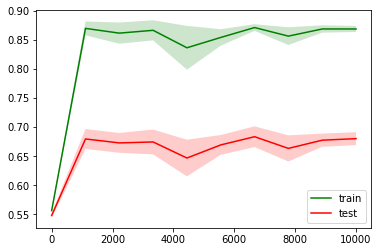

In [39]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [40]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, svm_params2, n_jobs=-1, cv=skf, return_train_score=True)
svm_grid_searcher2.fit(X_train, y_train)

Wall time: 39.9 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             error_score='raise-deprecating',
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=17, tol=0.0001, verbose=0),
             iid='warn', n_jobs=-1,
             param_grid={'C': array([0.00...
       0.17324138, 0.20768966, 0.24213793, 0.27658621, 0.31103448,
       0.34548276, 0.37993103, 0.41437931, 0.44882759, 0.48327586,
       0.51772414, 0.55217241, 0.58662069, 0.62106897, 0.65551724,
       0.68996552, 0.72441379, 0.75886207, 0.79331034, 0.82775862,
       0.8622069 , 0.89665517, 0.93110345, 0.96555172, 1.        ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, ver

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [41]:
i = np.argmax(svm_grid_searcher2.cv_results_['mean_test_score'])
accu_train = svm_grid_searcher2.cv_results_['mean_test_score'][i]
print('best score is {:.3f} correspond to C={} with index {}'.format(accu_train, svm_grid_searcher2.cv_results_['param_C'][i], i))

best score is 0.759 correspond to C=0.20768965517241378 with index 6


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

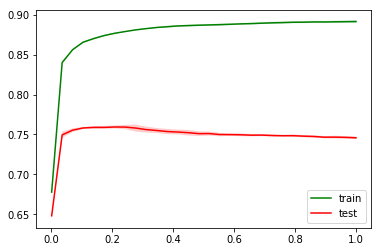

In [42]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [43]:
top_svm = LinearSVC(C=svm_grid_searcher2.cv_results_['param_C'][i], random_state=17)
top_svm.fit(X_train, y_train)

LinearSVC(C=0.20768965517241378, class_weight=None, dual=True,
          fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
          max_iter=1000, multi_class='ovr', penalty='l2', random_state=17,
          tol=0.0001, verbose=0)

In [44]:
svm_cv_acc = accuracy_score(y_valid, top_svm.predict(X_valid))

**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [45]:
with open('./answers/week4_ans4.txt', 'w') as fo:
    accu1 = '{:.3f}'.format(accu_train)
    accu2 = '{:.3f}'.format(svm_cv_acc)
    ans = accu1 + ' ' + accu2
    fo.write(ans)

## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [50]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    with open(path_to_X_pickle, 'rb') as fo:
        X = pickle.load(fo)
    with open(path_to_y_pickle, 'rb') as fo:
        y = pickle.load(fo) 
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    cv_accu = cross_val_score(estimator, X_train, y_train, cv=cv).mean()
    
    estimator.fit(X_train, y_train)
    y_predict = estimator.predict(X_valid)
    valid_accu = accuracy_score(y_valid, y_predict)
        
    return cv_accu, valid_accu

**Убедитесь, что функция работает.**

In [51]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

(0.7592959245298835, 0.7743541123488978)

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [55]:
!copy $PATH_TO_DATA\\X_sparse_10users.pkl $PATH_TO_DATA\\X_sparse_10users_s10_w10.pkl 
!copy $PATH_TO_DATA\\X_sparse_150users.pkl $PATH_TO_DATA\\X_sparse_150users_s10_w10.pkl 
!copy $PATH_TO_DATA\\y_10users.pkl $PATH_TO_DATA\\y_10users_s10_w10.pkl 
!copy $PATH_TO_DATA\\y_150users.pkl $PATH_TO_DATA\\y_150users_s10_w10.pkl 

        1 file(s) copied.
        1 file(s) copied.
        1 file(s) copied.
        1 file(s) copied.


In [56]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_10users_s{}_w{}.pkl'.format(session_length, window_size))
        path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_10users_s{}_w{}.pkl'.format(session_length, window_size))
        %time cv_score, valid_score = model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf, random_state=17, test_size=0.3)
        print('window size = {}, session length = {}, cv-accuracy = {:.4f}, valid accuracy = {:.4f}'.format(window_size,
                                                                                                            session_length,
                                                                                                            cv_score,
                                                                                                            valid_score))

Wall time: 9.67 s
window size = 10, session length = 15, cv-accuracy = 0.8251, valid accuracy = 0.8407
Wall time: 4.89 s
window size = 10, session length = 10, cv-accuracy = 0.7593, valid accuracy = 0.7744
Wall time: 13.3 s
window size = 7, session length = 15, cv-accuracy = 0.8512, valid accuracy = 0.8552
Wall time: 7.83 s
window size = 7, session length = 10, cv-accuracy = 0.8007, valid accuracy = 0.8070
Wall time: 4.6 s
window size = 7, session length = 7, cv-accuracy = 0.7519, valid accuracy = 0.7634
Wall time: 18.2 s
window size = 5, session length = 15, cv-accuracy = 0.8716, valid accuracy = 0.8777
Wall time: 10.6 s
window size = 5, session length = 10, cv-accuracy = 0.8175, valid accuracy = 0.8276
Wall time: 6.14 s
window size = 5, session length = 7, cv-accuracy = 0.7736, valid accuracy = 0.7884
Wall time: 3.8 s
window size = 5, session length = 5, cv-accuracy = 0.7244, valid accuracy = 0.7380
Wall time: 1min 19s


**<font color='red'>Вопрос 5. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [57]:
path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_10users_s{}_w{}.pkl'.format(15, 5))
path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_10users_s{}_w{}.pkl'.format(15, 5))
%time cv_score, valid_score = model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf, random_state=17, test_size=0.3)
with open('./answers/week4_ans5.txt', 'w') as fo:
    accu1 = '{:.3f}'.format(cv_score)
    accu2 = '{:.3f}'.format(valid_score)
    ans = accu1 + ' ' + accu2
    fo.write(ans)

Wall time: 17.7 s


По данным 10 пользователей можно сказать, что при ширине окна, совпадающей с длиной сессии, результаты получаются так себе.
Самое лучшее -- выбирать ширину окна поменьше, да длину сессии побольше.
В общем-то мы и получили, что лучший результат получается при минимальной ширине окна и максимальной длине сессии.

**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [59]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in [(5,5), (7,7), (10,10)]:
    path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_150users_s{}_w{}.pkl'.format(session_length, window_size))
    path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_150users_s{}_w{}.pkl'.format(session_length, window_size))
    %time cv_score, valid_score = model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf, random_state=17, test_size=0.3)
    print('window size = {}, session length = {}, cv-accuracy = {:.4f}, valid accuracy = {:.4f}'.format(window_size,
                                                                                                        session_length,
                                                                                                        cv_score,
                                                                                                        valid_score))

Wall time: 11min 46s
window size = 5, session length = 5, cv-accuracy = 0.4099, valid accuracy = 0.4233
Wall time: 9min 48s
window size = 7, session length = 7, cv-accuracy = 0.4377, valid accuracy = 0.4546
Wall time: 7min 37s
window size = 10, session length = 10, cv-accuracy = 0.4489, valid accuracy = 0.4691
Wall time: 29min 13s


**<font color='red'>Вопрос 6. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [69]:
estimator = LinearSVC(C=svm_grid_searcher2.best_params_['C'], random_state=17)

In [70]:
path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl')
path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_150users.pkl')
%time cv_score, valid_score = model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf, random_state=17, test_size=0.3)
with open('./answers/week4_ans6.txt', 'w') as fo:
    accu1 = '{:.3f}'.format(cv_score)
    accu2 = '{:.3f}'.format(valid_score)
    ans = accu1 + ' ' + accu2
    fo.write(ans)

Wall time: 5min 51s


## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо.**

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [71]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [72]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [142]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs=[2.905], multi_class='ovr', cv=skf, n_jobs=-1, random_state=17)
logit_cv_150users.fit(X_train_150, y_train_150)

Wall time: 9min 18s


LogisticRegressionCV(Cs=[2.905], class_weight=None,
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='ovr', n_jobs=-1,
                     penalty='l2', random_state=17, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [143]:
cv_scores_by_user = {}

for user_id, user_scores in logit_cv_150users.scores_.items():
    cv_scores_by_user[user_id] = user_scores.mean()
    print('User {}, CV score: {:.4f}'.format(user_id, user_scores.mean()))

User 6, CV score: 0.9959
User 13, CV score: 0.9963
User 15, CV score: 0.9951
User 16, CV score: 0.9919
User 28, CV score: 0.9903
User 31, CV score: 0.9944
User 33, CV score: 0.9934
User 39, CV score: 0.9859
User 46, CV score: 0.9978
User 49, CV score: 0.9951
User 50, CV score: 0.9943
User 53, CV score: 0.9936
User 65, CV score: 0.9969
User 66, CV score: 0.9949
User 82, CV score: 0.9963
User 85, CV score: 0.9963
User 89, CV score: 0.9906
User 92, CV score: 0.9943
User 100, CV score: 0.9945
User 102, CV score: 0.9913
User 103, CV score: 0.9803
User 105, CV score: 0.9969
User 106, CV score: 0.9947
User 118, CV score: 0.9910
User 119, CV score: 0.9967
User 120, CV score: 0.9941
User 126, CV score: 0.9950
User 127, CV score: 0.9914
User 128, CV score: 0.9846
User 138, CV score: 0.9973
User 158, CV score: 0.9971
User 160, CV score: 0.9968
User 165, CV score: 0.9973
User 172, CV score: 0.9965
User 177, CV score: 0.9967
User 203, CV score: 0.9975
User 207, CV score: 0.9874
User 223, CV score: 

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [144]:
class_distr = np.bincount(y_train_150.astype('int'))
data_len = y_train_150.size
acc_diff_vs_constant = {}
for user_id in np.unique(y_train_150):
    constant_score = (data_len - class_distr[user_id]) / data_len
#     print('User {}, CV score: {:.4f}'.format(user_id, constant_score))
    acc_diff_vs_constant[user_id] = cv_scores_by_user[user_id] - constant_score

In [151]:
num_better_than_default = (np.array(list(acc_diff_vs_constant.values())) > 0).sum()
print(num_better_than_default)

127


**<font color='red'>Вопрос 7. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

по рекомендациям с форума на удивление помогло именно `num_better_than_default` - 4. Что за чудеса, я так и не понял.

In [141]:
with open('./answers/week4_ans7.txt', 'w') as fo:
    ans = '{:.3f}'.format(123 / len(acc_diff_vs_constant))
    fo.write(ans)

**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [ ]:
y_binary_128 = ''' ВАШ КОД ЗДЕСЬ '''

In [ ]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [ ]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve ''' ВАШ КОД ЗДЕСЬ '''

In [ ]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

## Пути улучшения
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) 
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей


На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass.